## Access Mooring Timeseries Realtime Qc (Parquet)
This Jupyter notebook demonstrates how to access and plot mooring_timeseries_realtime_qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/a8f5c736-6eaa-47fb-a9eb-d778beb71701).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/mooring_timeseries_realtime_qc.ipynb).


In [1]:
dataset_name = "mooring_timeseries_realtime_qc"

## Install/Update packages and Load common functions

In [ ]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

In [2]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [3]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 40.7 ms, sys: 6.78 ms, total: 47.5 ms
Wall time: 464 ms


In [4]:
aodn_dataset.dataset.partitioning.schema

site_code: string
timestamp: int32
polygon: string

## List unique partition values

In [5]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('site_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['NRSMAI']
CPU times: user 421 µs, sys: 170 µs, total: 591 µs
Wall time: 556 µs


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


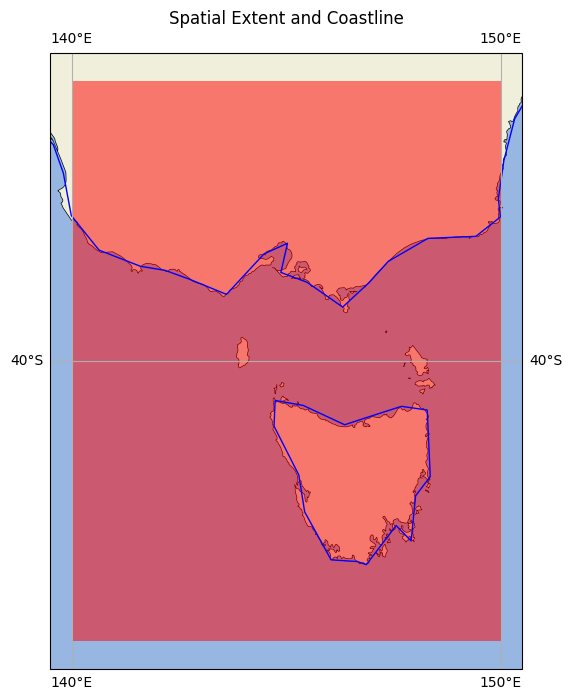

In [6]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
%%time
aodn_dataset.get_temporal_extent()

CPU times: user 46.8 ms, sys: 136 ms, total: 183 ms
Wall time: 323 ms


(Timestamp('2025-08-19 01:25:01'), Timestamp('2025-10-08 00:00:00'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [8]:
metadata = aodn_dataset.get_metadata()
metadata

2025-10-08 14:39:54,536 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_timeseries_realtime_qc.parquet


{'TEMP': {'type': 'float',
  'ancillary_variables': 'TEMP_quality_control',
  'standard_name': 'sea_water_temperature',
  'long_name': 'sea_water_temperature',
  'units': 'degC',
  'valid_min': -2.5,
  'valid_max': 40.0},
 'TEMP_quality_control': {'type': 'float',
  'flag_meanings': 'pass not_evaluated questionable bad missing',
  'flag_values': [1, 2, 3, 4, 9],
  'long_name': 'quality flag for sea_water_temperature',
  'quality_control_conventions': 'Ocean Data Standards, UNESCO 2013 - IOC Manuals and Guides, 54, Volume 3 Version 1',
  'standard_name': 'sea_water_temperature status_flag'},
 'DEPTH': {'type': 'double',
  'long_name': 'actual depth',
  'positive': 'down',
  'reference_datum': 'sea surface',
  'standard_name': 'depth',
  'comment': 'Depth computed using the Gibbs-SeaWater toolbox (TEOS-10) from latitude and relative pressure measurements (calibration offset usually performed to balance current atmospheric pressure and acute sensor precision at a deployed depth).',
  'uni

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [9]:
%%time
df = aodn_dataset.get_data(date_start='2025-08-01', 
                           date_end='2025-09-01',
                           lat_min=-50, 
                           lat_max=-30, 
                           lon_min=140, 
                           lon_max=150, 
                           )

df.info()

2025-10-08 14:39:55,147 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_timeseries_realtime_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TEMP                      342 non-null    float32       
 1   TEMP_quality_control      342 non-null    float32       
 2   DEPTH                     342 non-null    float64       
 3   DEPTH_quality_control     342 non-null    float32       
 4   DOX1                      48 non-null     float32       
 5   DOX1_quality_control      48 non-null     float32       
 6   PRES_REL                  342 non-null    float64       
 7   PRES_REL_quality_control  342 non-null    float32       
 8   PSAL                      342 non-null    float32       
 9   PSAL_quality_control      342 non-null    float32       
 10  TIME                      342 non-null    datetime64[ns]
 11  NOMINAL_DEPTH             342 non-null    float32       
 12  LATITUDE              

In [10]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_a8f5c736-6eaa-47fb-a9eb-d778beb71701_mooring_timeseries_realtime_qc_data-hash_c8cb7afc.csv.zip

In [11]:
print(df["NOMINAL_DEPTH"].unique())
print(df["site_code"].unique())

[85.   0.5]
['NRSMAI']


### Plot Temperature timeseries per Nominal Depth as subplots

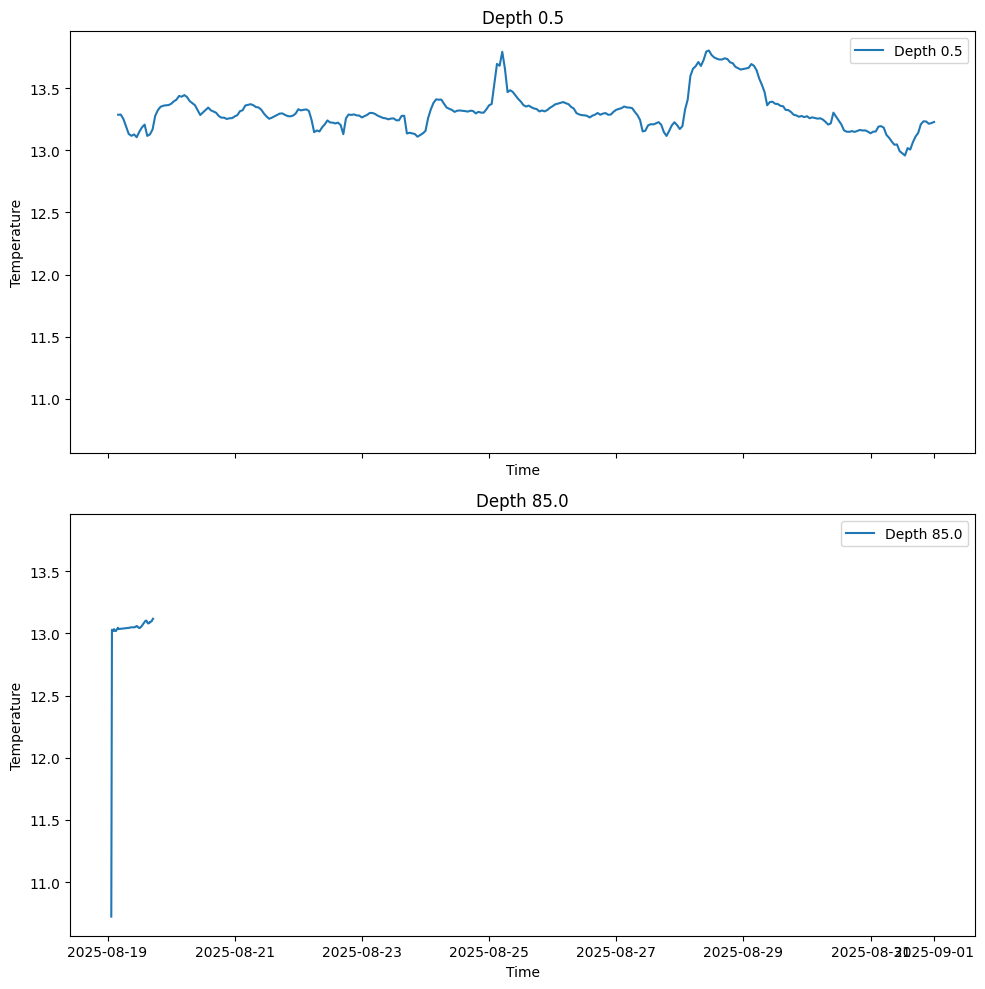

In [12]:
import matplotlib.pyplot as plt
# Unique NOMINAL_DEPTH values, sorted in ascending order
df = df[df["site_code"] == "NRSMAI"].sort_values('TIME')
depths = sorted(df['NOMINAL_DEPTH'].unique())

# Create subplots per NOMINAL_DEPTH values
n = len(depths)
fig, axes = plt.subplots(n, 1, figsize=(10, 5 * n), sharex=True, sharey=True)

# Plot data for each depth in a separate subplot
for ax, depth in zip(axes, depths):
    subset = df[df['NOMINAL_DEPTH'] == depth]
    ax.plot(subset['TIME'], subset['TEMP'], label=f'Depth {depth}')
    ax.set_title(f'Depth {depth}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Temperature')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Temperature timeseries of All nominal depth

/tmp/ipykernel_4088670/3436606694.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis_r', len(unique_depths))  # Use the reversed colormap


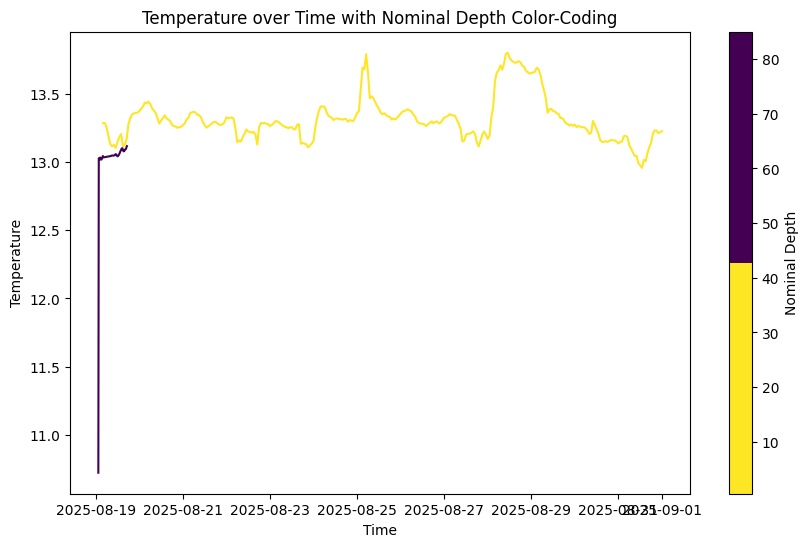

In [13]:
# Create a colormap
import numpy as np
import matplotlib.cm as cm
unique_depths = sorted(df['NOMINAL_DEPTH'].unique())
cmap = cm.get_cmap('viridis_r', len(unique_depths))  # Use the reversed colormap

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data with color coding
for i, depth in enumerate(unique_depths):
    subset = df[df['NOMINAL_DEPTH'] == depth]
    ax.plot(subset['TIME'], subset['TEMP'], label=f'Depth {depth}', color=cmap(i / len(unique_depths)))

# Create a colorbar
norm = plt.Normalize(vmin=min(unique_depths), vmax=max(unique_depths))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Nominal Depth', orientation='vertical')

# Labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Temperature over Time with Nominal Depth Color-Coding')
#ax.legend(title='Nominal Depth')

plt.show()


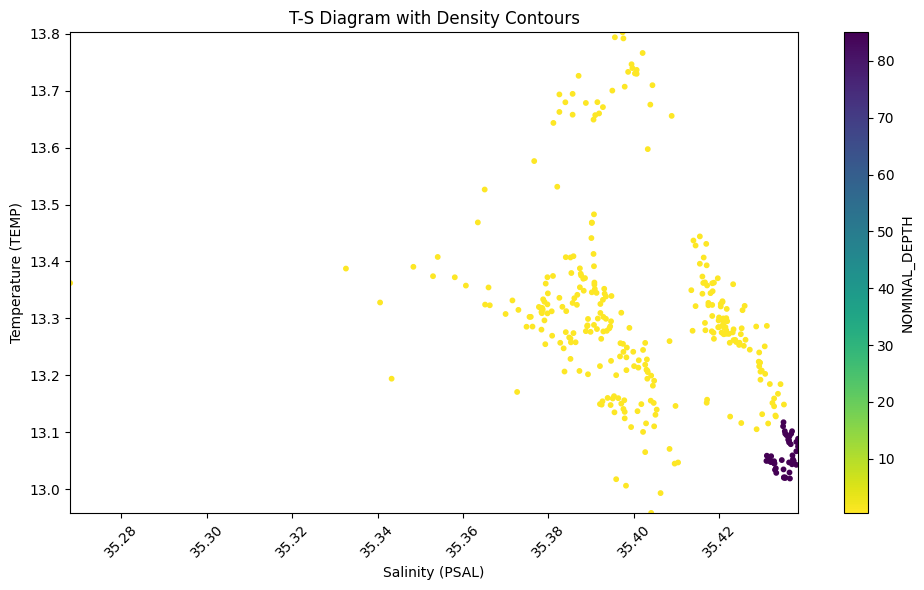

In [14]:
from DataQuery import plot_ts_diagram
plot_ts_diagram(df, temp_col='TEMP', psal_col='PSAL', z_col='NOMINAL_DEPTH')